<span style='font-family:Times New Roman'> Damian Kokot 426349 </span>

# <p style='font-family:Times New Roman;text-align:center'>Abstract</p>

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Data augmentation is a set of techiques to increase the amount of data. It generates new feature points from existing data by applying specific methods. For example noisy audio data can be synthetised by superimposing clean audio with a noisy audio signal in. Here, SpecAugment [1] and adding noise methods are implemented to the data provide by Oxford Nanopore Technologies (ONT) sequencing. Agumented data is then pass through RODAN [2] model to fit it and RNA basecaller is call out at the end of the pipeline. The aim of this work is to check how augmentation on data from ONT influence the basecaller performance by evaluating its accuracy.</p>

# <p style='font-family:Times New Roman;'> 1. Introduction </p>

<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Oxford Nanopore Technologies gives an oppurtinity to increase ability to sequence DNA and RNA directly without requiring amplification, producing long reads that can help identify splice isofroms unambiguously, determine poly(A) length, and can potentially capture information on base modifications. All methods of ONT have the same core, it records disturbance in electric current that goes along membrane caused by RNA/DNA sequence (passing through the membrane) that 'cuts' the current. The technology offers well performed sequencing method, although it is hampered by high error rates. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'> Translating current signal to DNA or RNA (basecalling) if very challenging. This case has several factors, for example, signal for each nucleotide is affected by surrounding bases thus to each nucleotides variable number of sequence values is assign, also such current signal are just simply noisy [3]. Given that there is a wide spectrum to improve basecallers. One of basecallers with state-of-the-art accuracy is Bonito [4] which is based on convolutional neural network (CNN) architecture. This model improve basecalling for DNA, but there is still little attention to RNA basecallers. However RODAN [2] undertakes the chalenge and perform very well with RNA data. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'>Although RODAN basecaller gives good results, the model have to be fit with big amount of data, which makes the training time long. Data augmentation might be perfect solution to reduce time of the training and with keeping, or even improving, accuracy of basecaller. Augementation deals well with uneven class balance within the datasets or small amount of data. It produces new and different examples to train datasets[5]. Here, newly formed data replace some examples from training and validation dataset, so amount of the data does not increase. Thus it will be examined if on reduce data with some augmentation model can fit well and give imporoved accuracy. </p>
<p style='font-family:Times New Roman;font-size:16px;text-align:justify'>In this work data augmentation is focused on two approaches: first is simple method that is based on adding the noise to the signal and second one is SpecAugment with an emphasis on time masking [1]. Two RODAN models were fitted each on seperate augmented dataset. Then models were compared with each other. RODAN basecaller is CNN model built with PyTorch library. </p>

# <p style='font-family:Times New Roman;'> 2. Materials and methods </p>

In [ ]:
import h5py
import numpy as np
from ont_fast5_api.fast5_interface import get_fast5_file

In [3]:
h5 = h5py.File('/home/dkokot/cbs_project/data/reduce-train-rna.hdf5', "r")
file = '/home/dkokot/cbs_project/data/reduce-train-rna.hdf5'

In [4]:
import spectogram

In [5]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

import model as md
import model_with_aug as mdaug

data = md.dataloader(recfile=file, seq_len=4096, elen=420)

data_loader = DataLoader(dataset=data, batch_size=1, shuffle=True, num_workers=8, pin_memory=False)

events = []
for i, (event, event_len, label, label_len) in enumerate(data_loader):
    if i < 2:
        events.append(event)
    else: break
# event = [torch.from_numpy(event).tolist()]
# spec = spectogram.time_masking(event)

Dataloader total events: 10000 seqlen: 4096 event len: 420


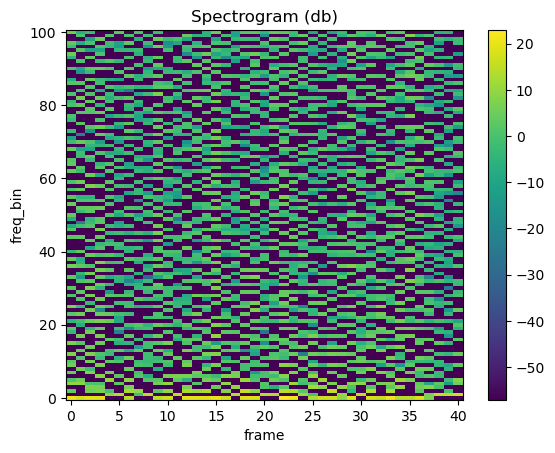

In [17]:
spec = spectogram.get_spectrogram(events[0])
plot_spectrogram(spec[0])

In [19]:
spec_time_mask = spectogram.time_masking(events[0])

In [35]:
# inversion to wave form (raw form of read from Oxford Naopore Technology (ONT) sequencing)
event = spectogram.to_db_and_inv(spec_time_mask)

In [36]:
event

tensor([[ 1.4663,  1.1657,  1.2903,  ..., -0.5425, -0.3922, -0.4875]])

In [37]:
spectogram.normalize(event)

tensor([ 1.6687,  1.2129,  1.4019,  ..., -1.3773, -1.1493, -1.2938])

In [29]:
spec_freq_mask = spectogram.freq_masking(events[0])

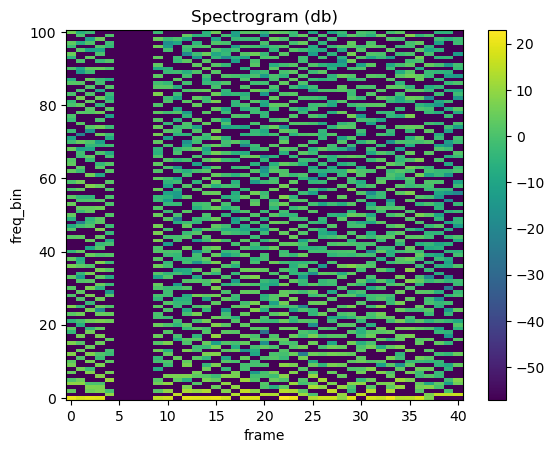

In [21]:
plot_spectrogram(spec_time_mask[0])

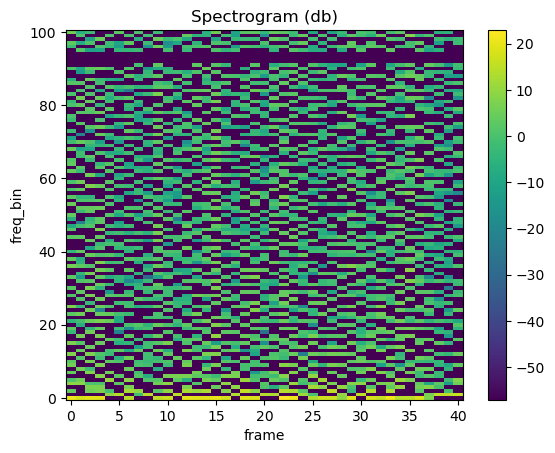

In [30]:
plot_spectrogram(spec_freq_mask[0])

In [25]:
events[0]

tensor([[ 1.4663,  1.1657,  1.2903,  ..., -0.3446, -0.2053, -0.3519]])

In [187]:
signal_start = 0
signal_end = len(e)
med, mad = ont.med_mad(e[signal_start:signal_end])
print(med, mad)
e = (e[signal_start:signal_end] - med) / mad

0.002678596 0.5742486470460891


In [188]:
e

tensor([ 6.0201e-01,  1.8717e+00, -4.1167e-01,  ..., -3.1568e+01,
         2.8081e+02,  4.1417e+02])

In [1]:
import os
os.system('python model_with_aug.py -c /home/dkokot/cbs_project/reduce-rna.config -D /home/dkokot/cbs_project/simple_aug_test -n SIMP_AUG_TEST -l --verbose | tee /home/dkokot/cbs_project/trainin_simple_aug.log')

Traceback (most recent call last):
  File "/home/dkokot/cbs_project/src/model_with_aug.py", line 612, in <module>
    train(config=config, args=args, arch=args.arch)
  File "/home/dkokot/cbs_project/src/model_with_aug.py", line 319, in train
    model = network(config=config, arch=arch, seqlen=config.seqlen).to(device)
  File "/home/dkokot/anaconda3/envs/cbs/lib/python3.9/site-packages/torch/nn/modules/module.py", line 907, in to
    return self._apply(convert)
  File "/home/dkokot/anaconda3/envs/cbs/lib/python3.9/site-packages/torch/nn/modules/module.py", line 578, in _apply
    module._apply(fn)
  File "/home/dkokot/anaconda3/envs/cbs/lib/python3.9/site-packages/torch/nn/modules/module.py", line 578, in _apply
    module._apply(fn)
  File "/home/dkokot/anaconda3/envs/cbs/lib/python3.9/site-packages/torch/nn/modules/module.py", line 578, in _apply
    module._apply(fn)
  File "/home/dkokot/anaconda3/envs/cbs/lib/python3.9/site-packages/torch/nn/modules/module.py", line 601, in _apply


0

# 5 References 
[3] Amarasinghe SL, Su S, Dong X, Zappia L, Ritchie ME, Gouil Q. Opportunities and challenges in long-read sequencing data analysis. Genome Biol. 2020;21(1):1–16.
<br>
[4]
<br>
[5] Mikołajczyk A, Grochowski M. Data augmentation for improving deep learning in image classification problem. IEEE. 2018. 10.1109/IIPHDW.2018.8388338